In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from sklearn.neighbors import KDTree



In [9]:
import pickle

from collections import Counter

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm, tqdm_notebook

import numpy as np

from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors        import NearestNeighbors

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

In [12]:
do_train          = True
do_eval           = True
calib_prop        = 0.1
model_path        = '../models/CIFAR_CNN.pt'
deep_knn_path     = '../models/deep_knn.pkl'
batch_size        = 128
device            = torch.device('cpu')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [13]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))   

In [14]:
cifar_cats = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [16]:
training_dataset = datasets.CIFAR10(
    './data',
    train = True,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

train_set_size               = len(training_dataset)
calib_size                   = round(calib_prop * train_set_size)
train_dataset, calib_dataset = random_split(
    dataset = training_dataset, 
    lengths = [train_set_size - calib_size, calib_size]
)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calib_dataset)}')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified
Train dataset size: 45000
Calibration dataset size: 5000


 66%|██████▌   | 111722496/170498071 [00:50<00:13, 4380101.75it/s]

In [17]:
test_dataset = datasets.CIFAR10(
    './data',
    train = False,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


deer


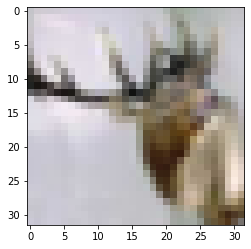

In [18]:
img, y = train_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

dog


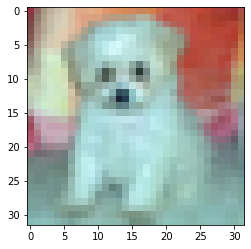

In [19]:
img, y = test_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

In [2]:
BATCH_SIZE = 100
EPOCHS = 3
NUM_CLASSES = 10
N_NEIGHBOURS = 60
IMAGE_SIZE = (28, 28)

In [4]:
class TorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 30, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 15, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(375, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, NUM_CLASSES)

        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            self.device = torch.device("cpu")
            print("Running on the CPU")

        self.to(self.device)

        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

        self.load_data()

        self.layer_outputs = [[], []]
        self.tree_list = []
        self.label_list = []

    def forward(self, x):
        x = x.to(self.device)
        self.output1 = self.pool1(F.relu(self.conv1(x)))
        self.output2 = self.pool2(F.relu(self.conv2(self.output1)))
        x = self.dropout1(self.output2)

        # print(x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        x = x.view(-1, 375)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x

    def batch_train(self):
        for epoch in range(EPOCHS):
            for data in self.trainset:
                batch_X, batch_y = data
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                self.zero_grad()
                outputs = self(batch_X)
                loss = self.loss_function(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
            print(loss)

    def load_data(self):
        train = datasets.MNIST("", train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

        test = datasets.MNIST("", train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

        self.trainset = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
        self.testset = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

    def prepare_neighbours(self):
        with torch.no_grad():
            for data in tqdm(self.trainset):
                X, y = data
                X, y = X.to(self.device), y.to(self.device)
                output = self(X)
                self.label_list.append(output)
                self.layer_outputs[0].append(self.output1.cpu().detach().numpy().flatten())
                self.layer_outputs[1].append(self.output2.cpu().detach().numpy().flatten())

            for i in range(2):
                tree = KDTree(np.array(self.layer_outputs[i]))
                self.tree_list.append(tree)

    def test_data(self):
        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testset:
                X, y = data
                X, y = X.to(self.device), y.to(self.device)
                output = self(X)

                dis1, nn1 = self.tree_list[0].query([self.output1.cpu().detach().numpy().flatten()], k=N_NEIGHBOURS)
                dis2, nn2 = self.tree_list[1].query([self.output2.cpu().detach().numpy().flatten()], k=N_NEIGHBOURS)
                print(dis1, dis2, nn1, nn2)
                for idx, i in enumerate(output):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
        print("Accuracy", round(correct / total, 3))



In [4]:
n = TorchModel()
n.load_data()
n.batch_train()
torch.save(n.state_dict(), "params.pt")
n.test_data()

0it [00:00, ?it/s]

Running on the CPU


 97%|█████████▋| 9633792/9912422 [00:10<00:00, 2001242.21it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 111186.22it/s]           

0it [00:00, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



 81%|████████  | 1335296/1648877 [00:01<00:00, 936672.38it/s]
1654784it [00:01, 1096123.67it/s]                             

0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



8192it [00:00, 42015.87it/s]            


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


9920512it [00:29, 2001242.21it/s]                             

tensor(-0.7981, grad_fn=<NllLossBackward>)
tensor(-0.7998, grad_fn=<NllLossBackward>)
tensor(-0.7751, grad_fn=<NllLossBackward>)


IndexError: list index out of range

In [22]:
nn = TorchModel()
nn.load_state_dict(torch.load("params.pt"))
nn.prepare_neighbours()
nn.test_data()




  1%|          | 4/600 [00:00<00:18, 31.73it/s]

Running on the CPU



 96%|█████████▌| 577/600 [00:19<00:00, 28.82it/s]


100%|██████████| 600/600 [00:19<00:00, 30.28it/s]


[[362.98962533 365.22881144 367.67938948 367.81905338 367.98010766
  369.68408391 369.93818011 370.09266141 370.85414903 370.97498725
  371.24904739 371.44822203 371.84414635 371.90457609 372.03874065
  372.10180302 372.32880273 372.52514436 372.5629593  372.64018373
  372.85548316 373.02346877 373.04476262 373.12665968 373.37904083
  373.41721281 373.45736435 373.57318657 373.64425229 373.65294536
  373.80247645 373.83016884 373.86940656 373.98696949 373.99357677
  374.05650602 374.14018773 374.15225184 374.24427663 374.31758298
  374.33179744 374.38371099 374.38481389 374.50806816 374.52069587
  374.57978739 374.61798905 374.61999861 374.65818512 374.71437691
  374.73401153 374.73954669 374.80226387 374.80753386 374.82056919
  374.8758912  375.02374924 375.04551817 375.08609547 375.08924304]] [[600.95028785 602.95339206 606.98209374 607.92070684 608.07304233
  608.19920997 609.33099596 609.61553405 609.62121291 609.70784947
  610.03399147 610.34322159 611.10606546 613.98600216 614.17

[[363.80209866 365.19335284 366.22815455 366.40019522 367.10172813
  368.07559557 368.14276984 368.39568231 368.49445424 369.48335943
  369.69260895 370.17716347 370.58589501 370.59979155 370.68296694
  370.69030823 370.71005134 370.73022458 370.75592027 370.76481649
  371.16390845 371.5627105  371.89730933 371.92922997 372.24673504
  372.261832   372.47650231 372.70322415 372.86732844 372.94326319
  373.07236407 373.14210614 373.50642261 373.5781523  373.59449639
  373.6155354  373.68148325 373.8127339  373.81809144 373.90629385
  373.90678474 373.95343714 373.97922056 374.06733685 374.09667498
  374.20452222 374.208294   374.21337881 374.2852165  374.31884961
  374.32810303 374.35893855 374.40829736 374.43043259 374.46084967
  374.48641095 374.53971025 374.5413014  374.55857251 374.59091414]] [[590.53961201 593.61980996 595.88636479 599.82717372 600.04105216
  600.14486587 601.21066386 602.09995421 603.62195982 604.52043643
  606.27817909 607.56954783 607.64806375 608.10648012 608.12

[[370.19524601 371.18361084 372.08776478 372.60909384 372.86835467
  372.98963037 373.08917639 373.37313864 373.52246966 373.67571641
  373.7647176  373.854895   374.09956313 374.31950638 374.58716524
  374.67555316 374.78830656 374.82222995 374.98613325 374.99564962
  375.01229214 375.09649129 375.12242087 375.22342866 375.22967216
  375.45126979 375.58876456 375.86445229 375.98844507 376.06693928
  376.07303245 376.08028162 376.17892218 376.32059599 376.36899023
  376.45841428 376.55285629 376.63002543 376.73372858 376.75937492
  376.84839175 376.88286903 376.93375489 376.94559389 376.98594084
  377.04121309 377.11415235 377.12563103 377.21676469 377.27565648
  377.32491166 377.41705213 377.43714312 377.45357352 377.45901117
  377.5149279  377.56813981 377.57407698 377.60001635 377.61557392]] [[609.13506884 609.45084296 610.89643125 611.52288416 612.18313809
  612.4284299  612.56130482 613.00391119 613.16962004 613.30207186
  613.39310627 613.54567534 613.719022   613.72377272 614.46

[[362.97455829 363.58705422 364.09122891 364.52610534 364.55813793
  364.71706688 364.76895755 364.88314478 364.94059554 364.94662226
  365.23632967 365.75297106 365.91870078 366.18591781 366.23183657
  366.3430824  366.38477357 366.62296103 366.73838569 366.85482862
  366.96503869 367.15173783 367.16955999 367.21635609 367.50001307
  367.56627272 367.60984188 367.63906469 367.83099841 367.85215231
  367.89389318 368.02707448 368.06973157 368.1363097  368.18722028
  368.21662533 368.23127345 368.30108497 368.39652716 368.42166429
  368.46670058 368.47617404 368.4978898  368.55438121 368.65666379
  368.66364665 368.80567138 368.85299686 368.88610311 368.98988414
  369.02802181 369.14030193 369.16142546 369.23148757 369.36738582
  369.38027014 369.5480198  369.56177629 369.71427197 369.73139757]] [[589.96267505 595.30006471 595.77528008 597.12043329 597.13000423
  598.36405615 598.90119408 599.56087225 600.46570569 600.70177243
  600.85838753 602.05695165 602.60968482 602.89759148 602.95

[[365.35960006 366.11461213 366.47413717 367.07658613 367.09842837
  367.09967619 367.16482777 367.22325016 367.35112631 367.61933121
  367.83086425 367.87113695 367.94813659 368.17990298 368.20856624
  368.23273562 368.52579311 368.61958877 369.12242991 369.21462767
  369.25981501 369.29568033 369.40154463 369.47093595 369.55678277
  369.62550413 369.65923348 369.7000718  369.94974036 369.95367162
  370.16648777 370.17723031 370.24496149 370.30843649 370.44271146
  370.59891803 370.8391129  370.94878344 371.02346083 371.10155962
  371.11110964 371.11706529 371.15057636 371.18137355 371.19584934
  371.19688689 371.33378094 371.35607313 371.38813373 371.39657697
  371.42116002 371.47762554 371.54316436 371.58510443 371.60114834
  371.62452208 371.65566524 371.66352368 371.70620779 371.70761105]] [[598.72065136 599.40666822 599.81525756 600.62083263 602.27884291
  602.36322386 603.14197427 603.88461368 604.4261824  604.82903637
  604.86088593 604.92798865 604.99765425 605.11274374 605.32

[[363.01181458 364.30326938 365.45140256 365.79803981 365.91472255
  366.31339371 366.76307167 368.30802362 368.41134271 368.72934097
  368.7317075  368.75988423 368.88663978 368.91535918 368.9445059
  369.51921599 369.85942429 369.96450797 370.10405633 370.15671665
  370.33462018 370.41001187 370.42216465 370.51299997 370.57836266
  370.60485388 370.75059961 370.84786498 370.9670737  370.98158094
  371.01019462 371.01783875 371.02137675 371.03192821 371.30818945
  371.35184132 371.4136091  371.46411119 371.66272754 371.70154834
  371.75295229 371.82182569 371.8680868  371.86993942 371.87551957
  371.88807299 371.89873543 371.9636695  372.03041008 372.11849167
  372.13738266 372.14908311 372.29019797 372.38655601 372.4084557
  372.45639596 372.48470889 372.49122373 372.52360701 372.52612111]] [[597.54410885 599.69341098 601.27558022 601.48189557 602.32268375
  602.80733532 603.11402136 603.79773686 604.04432923 604.28218842
  605.04273933 605.07491829 605.33221024 605.78677881 605.8187

[[361.59478291 362.19443792 363.41867098 365.48176124 367.7274788
  367.99843334 368.00803805 368.02515984 368.13256275 368.76969798
  369.12973424 369.41712947 369.68422061 369.82933992 369.85769263
  370.03525783 370.12324599 370.2156549  370.42150829 370.70791125
  370.74173321 370.88809598 370.93216653 370.98634908 371.00948219
  371.03135119 371.11981671 371.2698684  371.2974934  371.53998788
  371.58701018 371.74914502 371.98241116 371.98459997 372.01718924
  372.0504752  372.05352272 372.10268904 372.18208402 372.2078533
  372.2466081  372.30424417 372.32585754 372.43855111 372.4568231
  372.49089004 372.51040237 372.54749532 372.59047514 372.63695077
  372.67287661 372.70229396 372.79156476 372.79255481 372.80348892
  372.82550244 372.8534662  372.88966698 372.94725718 372.95732133]] [[589.52614528 593.99404921 598.63389989 600.7588699  601.65372044
  603.36998219 603.86443718 604.12236928 604.50189819 604.53080534
  604.56473704 605.20564071 605.46742851 605.47354006 605.97003

[[365.4176232  369.66030702 370.30810271 370.37276019 370.77367945
  370.9342608  371.27960999 371.50691338 371.76032053 371.79057711
  371.83116908 372.45050886 372.51469203 372.59825799 372.61751849
  372.62839961 372.94613263 373.23818443 373.44246005 373.63192354
  373.99933219 374.04383969 374.06914981 374.07918426 374.17442344
  374.21737952 374.34632442 374.44978354 374.47528274 374.49385375
  374.60622846 374.75723664 374.79209884 374.91819615 374.96451886
  374.99601674 375.08202854 375.13288254 375.17454133 375.17691862
  375.29794976 375.32007234 375.38690841 375.40456711 375.43462942
  375.46059714 375.54568057 375.59748131 375.62454096 375.70771915
  375.71728421 375.78400218 375.7968874  375.90395415 375.97465094
  376.02502101 376.13610533 376.13884609 376.23356674 376.26902814]] [[607.08923123 608.76259468 610.08033353 612.69923205 612.78702965
  612.91104209 613.16922302 613.2999916  613.79621088 614.54079681
  614.56895794 615.2351524  615.34350858 615.76092549 616.02

[[363.88371811 366.34702903 367.2632349  367.43271563 368.40339912
  368.94730224 369.11217145 369.29824771 369.82946453 369.84169701
  369.97758944 370.10164974 370.20191585 370.33366575 370.34549032
  370.34896855 370.37872423 370.4841153  370.5500812  370.72696356
  370.85509371 370.89033699 370.94411568 371.07889669 371.62526118
  371.69716506 371.90461316 371.96126621 371.98116459 372.01110692
  372.13469368 372.15541029 372.19712305 372.33208614 372.37159286
  372.43957869 372.50809091 372.50999571 372.90359854 372.92922798
  372.93311419 373.0097001  373.05211102 373.13021125 373.16041798
  373.19664499 373.23639605 373.24407652 373.3779075  373.3954913
  373.56247283 373.58257993 373.61189107 373.6322584  373.65943397
  373.70116707 373.71279953 373.7318924  373.87107138 373.98956241]] [[603.93777733 605.2098038  607.09369664 608.21225912 608.61821305
  608.70564919 608.80567514 609.79370705 610.3363164  610.43552054
  610.53438033 610.65895612 612.27441681 612.31236077 612.624

[[368.70967632 369.58041769 369.84873066 370.28129737 370.5367803
  370.94397652 370.95646603 371.24171589 371.35457261 371.5194953
  371.54741328 371.79083387 371.92942829 371.94396445 372.16008803
  372.16419432 372.33300487 372.47293377 372.54906249 372.56693811
  372.58519789 372.63051802 372.72873578 372.90373022 372.9587639
  373.31776309 373.35074571 373.35164419 373.35661337 373.35952762
  373.59843756 373.73470868 373.77795606 373.84527841 373.89263447
  373.93657893 373.94837746 373.99819145 374.12194534 374.27945432
  374.29172864 374.29392391 374.3479511  374.52144776 374.54558247
  374.75751489 374.81143866 374.89868707 374.93074735 374.95244389
  374.96644492 375.04976029 375.05380989 375.14134943 375.17159968
  375.22117985 375.23498774 375.2418118  375.30310227 375.42425418]] [[603.93493563 604.49323079 605.12219262 605.89799277 607.56006809
  608.40465148 610.43154242 610.91956347 611.5705081  612.73089397
  613.81770613 613.96490751 614.05926552 614.2022665  614.32337

[[367.26898504 367.4681904  367.97768921 368.51627384 368.87360234
  371.25176541 371.90663826 372.37248211 372.44427371 372.80697406
  372.98653066 372.99630137 373.29393857 373.3318592  373.39063458
  373.48208463 373.54998022 373.89177772 373.89968791 373.9170061
  373.98876812 374.08986448 374.11295446 374.26116077 374.38500499
  374.45217984 374.47233834 374.49387139 374.67688274 374.93382593
  375.07733862 375.09725174 375.11359335 375.16981543 375.21578726
  375.35882758 375.40437476 375.41683102 375.45611497 375.50454351
  375.67999187 375.79840864 375.79999612 375.8609703  376.02150998
  376.06002618 376.24809306 376.37950663 376.39973806 376.54448886
  376.57248658 376.62839731 376.71193579 376.73589374 376.74063021
  376.7739889  376.77960068 376.8305687  376.88250553 376.93340074]] [[602.02031092 603.66430735 604.26219839 605.07288447 606.48034647
  606.88106237 608.97188438 609.38924435 609.43514229 610.83967402
  613.20724696 613.70990103 613.78351222 614.13453278 614.255

[[365.20914298 366.10651653 366.39354004 366.62048493 367.09322875
  367.38456842 368.11552753 368.44128887 368.58406209 368.95910475
  369.02092636 369.03549937 369.24689047 369.27656238 369.44701655
  369.68992242 369.77248577 370.13323792 370.4085661  370.43688966
  370.49585101 370.56818993 370.5820116  370.63139129 371.00059349
  371.03575605 371.10815696 371.10873873 371.20539628 371.40811887
  371.41671624 371.56964266 371.58696988 371.6483507  371.66820468
  371.66861869 371.71818767 371.73215724 371.73899482 371.76662374
  371.81404488 371.95418201 371.99425495 372.03812213 372.13261521
  372.14990392 372.29510782 372.3403063  372.3470643  372.35262678
  372.35715691 372.48951817 372.51588841 372.57004338 372.58494978
  372.64020929 372.75334049 372.82386712 372.83156036 372.85234124]] [[601.51548706 604.04571317 605.46437535 606.22591714 607.20530885
  608.92304002 609.41168047 610.41222224 610.72518512 610.87755013
  611.23547461 611.28325743 611.35764833 611.52792104 611.92

[[367.02933178 368.26970367 368.45163906 368.51961516 368.65673072
  368.78726704 368.92164141 369.31603926 369.34719359 369.43754958
  369.70566077 369.8598361  369.8931852  370.04595599 370.07240371
  370.1465427  370.32312718 370.41956715 370.73067982 370.78876915
  371.06831729 371.18628372 371.23143567 371.25332424 371.36574049
  371.60433333 371.60803789 371.73074508 371.75408376 371.80498455
  371.87280388 371.96555055 371.9714059  372.13117316 372.32378075
  372.4260062  372.4682632  372.48186726 372.54568783 372.56348158
  372.58172621 372.59647952 372.61410985 372.64875062 372.67471702
  372.67484984 372.68187164 372.88763445 372.89125269 372.89295234
  373.00207125 373.01954035 373.02056657 373.14491504 373.1623195
  373.21095806 373.28132874 373.35754311 373.36141    373.45108518]] [[602.34496898 603.53149747 604.09004083 605.26773047 605.54431166
  606.61815682 606.84403255 606.99588141 607.22823598 607.79568953
  608.39968389 608.52333377 608.52414158 609.63675795 609.665

[[370.82004157 372.2569747  372.66819631 373.57778704 373.59952336
  373.75100746 374.46526442 374.51221005 374.53422703 374.53669195
  374.55008594 374.57932305 374.59313009 374.91990319 375.08697897
  375.25204188 375.30745858 375.41359697 375.49480929 375.52238367
  375.58993339 375.6106901  375.64938863 375.80311567 376.04865798
  376.09348688 376.16061331 376.20330567 376.20969404 376.3697097
  376.4739143  376.56584168 376.5692373  376.66375118 376.70311358
  376.72677131 376.76492905 376.83710348 376.93444096 377.03356829
  377.04444849 377.05254523 377.06559857 377.066006   377.1528526
  377.15998237 377.27552823 377.39645425 377.40036534 377.51279148
  377.51344663 377.52502891 377.57970774 377.59051554 377.67484306
  377.69633799 377.74243342 377.78175192 377.89155374 377.93668868]] [[613.65874119 616.18085747 618.26518709 619.01641004 619.57566546
  619.80509471 620.45174338 620.50238484 620.66707669 620.90872495
  621.27291669 621.9437762  622.08657802 622.47396166 622.4750

[[372.42833772 374.62849019 376.53528774 376.54706537 376.88947906
  376.93476748 377.30255183 377.75025405 377.82599659 377.9499166
  377.97974188 378.2653221  378.39008883 378.44988249 378.52695917
  378.58813776 378.75580244 378.94852638 379.14830417 379.27691066
  379.30068882 379.4266394  379.48900702 379.6500958  379.67808783
  379.72743232 379.91624322 379.99680352 380.07712051 380.50689779
  380.54635048 380.61786558 380.64080728 380.67151076 380.76857538
  380.8450914  380.85306782 380.8881817  380.89896142 381.06003646
  381.06643972 381.20427901 381.30852938 381.31990902 381.32755748
  381.41509029 381.49420558 381.52412614 381.58786764 381.63131673
  381.66726185 381.66882648 381.80086291 381.86233503 381.88014409
  381.95921009 381.9716034  381.99605715 382.0236266  382.0994637 ]] [[613.86251362 613.88682024 618.03667719 618.70945134 621.16290236
  621.65034372 623.75800003 624.89730188 624.99990973 625.57768489
  626.04476179 627.27821471 627.58715031 628.11229637 628.801

[[389.95305608 390.33713576 390.34846881 391.3214355  391.66599493
  392.60380225 392.87153458 392.89294237 393.06497864 393.07095261
  393.11492163 393.34974963 393.42936455 393.43220618 393.55265613
  393.68875925 393.86804541 394.1541197  394.16029134 394.18439611
  394.1862673  394.22062492 394.23380552 394.28001068 394.28595372
  394.29612204 394.32770055 394.46172823 394.52186049 394.79894284
  394.93245712 394.93482641 395.06896376 395.17613212 395.26252224
  395.2866624  395.31792602 395.3965592  395.44490989 395.58675465
  395.61804734 395.71454882 395.72196458 395.74333791 395.8582361
  395.88700635 395.96418299 396.05011167 396.17148306 396.1773325
  396.42731905 396.44152294 396.55621024 396.5931617  396.6115295
  396.63948994 396.77192115 396.79538451 396.80190118 396.83053294]] [[640.70188603 640.80452406 641.36196842 645.81089118 646.5303928
  646.92047983 647.06230183 648.03970636 648.33625031 648.3733932
  649.07907854 649.22304483 649.58801339 649.72934818 649.8988151

[[372.74149729 374.56912328 374.78687384 375.29264684 375.42699102
  375.81928585 376.29597052 376.3311943  376.47412321 376.65339232
  377.29766177 377.62630449 377.7183436  377.99669829 378.05310965
  378.06774843 378.12123015 378.36122855 378.36872551 378.37706535
  378.39811843 378.51438429 378.60816206 378.64863519 378.66800734
  378.86282389 378.97826061 378.9887562  379.21917602 379.3932703
  379.52314445 379.60913472 379.66514667 379.92618699 379.9269979
  379.965773   380.05036398 380.09554111 380.17705828 380.19788701
  380.23349372 380.38191175 380.45511718 380.53569446 380.55095407
  380.55839526 380.56032662 380.86270108 380.88985268 380.98987249
  381.08117435 381.18251533 381.19281226 381.36089778 381.39941243
  381.43397455 381.53478052 381.53920712 381.58129271 381.58571124]] [[600.59686154 602.86834833 604.21419036 604.39918494 604.97185231
  606.04303598 606.10535807 606.16399694 608.22490016 608.41503554
  608.62045638 609.00262422 609.30698392 609.80210299 610.3002

[[370.94209821 373.10597743 373.84570212 373.97602338 374.19139236
  375.15481132 375.26907326 375.43243521 375.49860578 375.75612422
  376.08840705 376.41163174 377.29045145 377.34315374 377.63353176
  378.12392484 378.16959218 378.17916937 378.1832249  378.26176336
  378.49680699 378.5423238  378.59491014 378.70186468 378.86314006
  379.04336942 379.21109488 379.29824232 379.32052236 379.59049318
  379.6303042  379.70106782 379.70797187 379.77232823 379.92300497
  379.97965241 380.00878694 380.22117924 380.39457385 380.43067665
  380.45440846 380.52734682 380.60957401 380.65142681 380.66441895
  380.66624053 380.71578407 380.77741799 380.80403408 380.80520632
  380.80947754 380.96137318 381.19188207 381.22754004 381.25946523
  381.35512251 381.42164423 381.56557765 381.65531103 381.84209229]] [[630.7752325  631.22678214 631.82869798 636.64009358 639.89279492
  640.23786967 641.08732187 641.25307692 641.3246998  641.3585517
  641.45275412 641.54571351 641.58519446 642.05722132 642.070

[[366.59682674 367.20914585 367.62829247 368.14742792 368.60116704
  368.76440772 368.81701646 368.96266885 369.00851444 369.07979934
  369.08899469 369.63079745 369.80956245 370.04122906 370.71975198
  370.86744686 371.04740897 371.20277761 371.4011258  371.42273859
  371.56490611 371.71219235 371.80239103 372.12223865 372.15591492
  372.17014152 372.20781381 372.21156458 372.2257317  372.24519713
  372.34344799 372.43824321 372.4669642  372.51896339 372.57484044
  372.58354273 372.65502437 372.76063497 372.78473469 372.89798081
  372.90217055 373.01911502 373.02718672 373.06148595 373.15596079
  373.18098551 373.20588452 373.233087   373.38649957 373.43968253
  373.44139676 373.5165421  373.76338159 373.80704444 373.8415525
  373.98670063 374.05772528 374.07398221 374.08920507 374.18008201]] [[592.29783598 594.79283976 596.78797401 597.96329799 598.20698879
  598.93602981 599.8577437  600.20022968 600.43049931 600.85816751
  601.50388384 601.55454636 602.01364398 603.26384882 603.497

[[364.8800652  365.00907101 365.73131389 367.86481287 368.49158966
  369.54289903 369.61505444 369.71118736 369.99841107 370.06238407
  370.18384436 370.23016398 370.33455981 370.43554923 370.58572736
  370.63421563 371.24687417 371.32145798 371.39633482 371.5314556
  371.59193169 371.7073583  371.71665878 371.74381111 371.79292659
  371.87015562 371.87946534 372.06578437 372.12338142 372.12627851
  372.13359396 372.15314068 372.16158953 372.31840642 372.3410055
  372.40194723 372.47460066 372.50433281 372.57234873 372.66804114
  372.75118972 372.78844565 372.79889912 372.8029111  372.82557231
  372.83966772 372.86670296 373.03354503 373.27740649 373.32058104
  373.32080786 373.48344908 373.55338508 373.58841918 373.59564398
  373.60943125 373.7407467  373.77376952 373.77891831 373.78314421]] [[608.46583913 610.28407495 610.82884734 611.76920898 611.88485712
  611.97187471 612.88652844 613.50453241 613.53283566 614.31365735
  614.57991709 614.69377047 615.03520815 615.17974155 615.2470

[[382.1258824  382.32952565 384.30356414 384.31225444 384.489722
  384.85246289 385.00707836 385.19651759 385.30273205 385.97608097
  386.13332591 386.14507078 386.15969109 386.18704584 386.44677063
  386.48808331 386.64446822 386.84966168 386.88937618 386.98893128
  387.01468164 387.03252281 387.27061533 387.45340742 387.4625347
  387.47978337 387.53542164 387.72906114 387.72980869 387.73520955
  387.8211571  387.91505312 388.01094939 388.09808039 388.11986416
  388.35144854 388.43669955 388.48310814 388.48801786 388.50755552
  388.59402867 388.69506924 388.72718464 388.73867002 388.77325414
  388.82186049 388.95185536 389.02574676 389.02651958 389.06018991
  389.27148721 389.3782209  389.41513478 389.44845627 389.59959983
  389.61320776 389.65174153 389.75359125 389.77519003 389.78869489]] [[623.72217818 624.48328436 624.57289806 628.30467671 628.33667123
  628.35492545 628.77942868 629.14888468 629.75886987 629.79613452
  630.02441658 630.25973768 630.47838074 631.03303733 631.06956

[[381.69474743 383.99349148 384.40440331 384.75823197 384.92822989
  385.27677218 385.28268116 385.5195187  385.94211131 386.82536395
  386.8372291  386.97144632 387.0020092  387.45831624 387.46019936
  387.47266613 387.58329403 387.60802961 387.74900655 388.1845925
  388.35582859 388.44155254 388.73524338 388.80163307 388.91154074
  388.91421201 389.14584155 389.15153492 389.177326   389.23737764
  389.25194697 389.44923757 389.52058494 389.57243886 389.59154794
  389.77141513 389.8113619  389.86836944 389.93973704 390.05447683
  390.16819725 390.17584146 390.18904989 390.32464835 390.34217095
  390.47817545 390.5487518  390.56104912 390.59520393 390.64753884
  390.67517685 390.70505205 390.70859969 390.80006837 390.80751268
  390.8538001  390.89948209 390.93646975 390.98143252 391.01526779]] [[637.25535495 637.53946385 641.15033021 642.41191252 644.19983416
  644.38086105 644.63696266 644.66304978 646.61194216 646.64408454
  646.85837705 647.23098756 647.67029267 647.96321026 648.749

[[372.55322534 372.70005141 374.11527716 374.29565167 374.58117576
  374.82438959 375.07974775 375.19191193 375.59778416 376.02171302
  376.06783337 376.10272328 376.13764892 376.21680735 376.68164414
  376.68615566 377.08961616 377.16212652 377.32626717 377.34146674
  377.76545933 377.76924229 377.83893112 377.85358616 377.94191502
  378.09698417 378.20181531 378.26398812 378.3322651  378.34066254
  378.35581293 378.48512055 378.58711884 378.61338763 378.6858422
  378.68934947 378.7919546  378.93365072 379.26582395 379.38398165
  379.47380081 379.52777722 379.55728399 379.59602099 379.64506692
  379.67058698 379.79995344 379.82315115 379.82465402 380.04577442
  380.12884957 380.19895838 380.33670877 380.44904388 380.49007455
  380.53142025 380.58387477 380.58745201 380.58857751 380.67712739]] [[609.64782186 612.22410797 612.37388669 613.30763163 616.56966762
  618.37241301 618.9920758  619.03388773 619.26401722 619.40338824
  619.90397989 619.96534065 620.17332558 620.18384575 620.213

[[370.21185913 372.78287216 374.39898537 375.11038216 375.49659097
  376.07268965 376.56282798 377.15173163 377.48560933 377.51118082
  377.77142429 377.9422468  378.54021654 378.71648793 379.234281
  379.26285347 379.39890984 379.66064605 379.8427308  379.85423086
  379.88776862 380.02727495 380.16453516 380.31286971 380.3197287
  380.45194672 380.49333285 380.49870983 380.70641793 380.8546458
  381.12773135 381.20583368 381.36074294 381.40258806 381.40854769
  381.4617975  381.55453026 381.59244195 381.60128586 381.6108075
  381.66102364 381.68555287 381.71700223 381.81767712 381.97576467
  382.00598603 382.03318796 382.0937475  382.09813843 382.11984761
  382.29782231 382.29838525 382.37325273 382.45909628 382.48985051
  382.49318677 382.58258206 382.60687493 382.61922882 382.63392835]] [[588.34153281 594.96181073 597.59727656 599.1507333  599.42993384
  599.78745109 600.5064536  601.02131506 601.58278156 602.02421406
  602.640523   603.41069159 604.29120373 604.53952692 604.6539819

[[359.00222594 360.19766836 362.72084921 364.58612751 365.58245729
  365.89187496 365.97067202 366.35164288 366.41614311 366.60047513
  366.92515076 366.99217339 367.22918626 367.42198611 367.43285278
  367.83221842 368.08170733 368.10330142 368.72405884 368.85971934
  368.88905213 368.89176244 369.23018611 369.33615726 369.37772687
  369.38784563 369.45839345 369.52021686 369.53163762 369.62588011
  369.6905711  369.76761901 369.89597587 369.89874858 369.97197807
  370.00991999 370.07944452 370.09514731 370.11424122 370.15841138
  370.19152427 370.26743165 370.44739828 370.47367544 370.56756539
  370.608646   370.703893   370.82828076 370.85281343 370.94758767
  370.99383952 371.09172965 371.11789458 371.13999825 371.20672113
  371.37929959 371.39889741 371.40489879 371.41349217 371.44750433]] [[559.91874639 570.59511308 571.98191506 574.29760732 574.56634234
  574.71128915 576.45052848 576.54998911 576.57634393 577.30846408
  577.47425037 578.19106944 578.30144445 578.4611056  578.47

In [23]:
class DeepKNN():
    def __init__(self, model, device, train_dataset, calib_dataset, 
                 batch_size, n_neighbors, n_embs):
        self.model         = model
        self.device        = device
        self.train_dataset = train_dataset
        self.calib_dataset = calib_dataset
        self.batch_size    = batch_size
        self.n_neighbors   = n_neighbors
        self.n_embs        = n_embs
        (
            self.conv_features, 
            self.train_targets, 
            self.train_predictions
        )                    = self._build_emb_spaces()
        self.neighs          = self._build_neighs()
        self.alpha_calib_sum = self._build_calibration()
        
    def _build_emb_spaces(self):
        print('Building the embedding spaces from the training set.')
        sequential_train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            shuffle    = False,
            batch_size = self.batch_size
        )
        
        conv_features = [[] for _ in range(self.n_embs)]
        targets       = []
        predictions   = []
        print('\tRunning predictions')
        self.model.eval()
        for X, y in sequential_train_loader:
            X                  = X.to(self.device)
            *out_convs, y_pred = self.model(X)
            for i, out_conv in enumerate(out_convs):
                conv_feat = out_conv.view(out_conv.size(0), -1).cpu().detach().numpy()
                conv_features[i].append(conv_feat)
            targets.append(y.numpy())
            predictions.append(y_pred.cpu().detach().numpy())
        print('\tConcatenating results')
        conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
        targets       = np.concatenate(targets)
        predictions   = np.concatenate(predictions, axis = 0)
        
        return conv_features, targets, predictions

    def _build_calibration(self):
        print('Building calibration set.')
        sequential_calib_loader = torch.utils.data.DataLoader(
            self.calib_dataset,
            shuffle    = False,
            batch_size = self.batch_size
        )
        alpha_by_batch = [self._alpha(X, y.numpy()) for X, y in sequential_calib_loader]
        alpha_values   =  np.concatenate(alpha_by_batch)
        c              = Counter(alpha_values)
        alpha_sum_cum  = []

        for alpha_value in range(self.n_embs * self.n_neighbors, -1, -1):
            alpha_sum_cum.append(c[alpha_value] + (alpha_sum_cum[-1] if len(alpha_sum_cum) > 0 else 0))
            
        return np.array(alpha_sum_cum[::-1])
    
    def _build_neighs(self):
        print('Building Nearest Neighbor finders.')
        return [
            NearestNeighbors(
                n_neighbors = self.n_neighbors, 
                metric      = 'cosine'
            ).fit(feats) 
            for feats in self.conv_features
        ]
        
    def _alpha(self, X, y):
        neighbors_by_layer, _  = self._get_closest_points(X)
        closest_points_classes = self.train_targets[neighbors_by_layer]
        same_class_neighbors   = closest_points_classes != y.reshape(y.shape[0], 1, 1)
        same_class_neighbors   = same_class_neighbors.reshape(-1, self.n_neighbors * self.n_embs)
        alpha                  = same_class_neighbors.sum(axis = 1)
        
        return alpha

    def _compute_nonconformity(self, X):
        neighbors_by_layer, _  = self._get_closest_points(X)
        closest_points_label   = self.train_targets[neighbors_by_layer]
        closest_points_label   = closest_points_label.reshape(-1, 24)
        nonconformity          = [(closest_points_label != label).sum(axis = 1) for label in range(10)]
        nonconformity          = np.stack(nonconformity, axis = 1)
        
        return nonconformity
    
    def _compute_p_value(self, X):
        nonconformity = self._compute_nonconformity(X)
        empirical_p_value      = self.alpha_calib_sum[nonconformity] / len(self.calib_dataset)
        
        return empirical_p_value
    
    def _get_closest_points(self, X):
        *out_convs, y_pred = self.model(X.to(device))
        neighbors_by_layer = []
        for i, (neigh, layer_emb) in enumerate(zip(self.neighs, out_convs)):
            emb       = layer_emb.detach().cpu().view(X.size(0), -1).numpy()
            neighbors = neigh.kneighbors(emb, return_distance = False) 
            neighbors_by_layer.append(neighbors)
        return np.stack(neighbors_by_layer, axis = 1), y_pred

    def predict(self, X):
        p_value     = self._compute_p_value(X)
        y_pred      = p_value.argmax(axis = 1)
        # Partitioning according to the second to last value in order to compute
        # credibility and confidence
        partition   = np.partition(p_value, -2)
        credibility = partition[:, -1]
        confidence  = 1 - partition[:, -2]
        
        return y_pred, confidence, credibility
    
    def predict_interpretation(self, X, y = None):
        img_data = lambda img: reverse_normalize(img.to(device).squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
        plt.figure(figsize = (12, 6))
        gs       = gridspec.GridSpec(4, 4 + self.n_neighbors)
        ax_big   = plt.subplot(gs[:, :4])
        ax_grid  = [[plt.subplot(gs[i, j]) for j in range(4, 4 + self.n_neighbors)] for i in range(4)]
        ax_big.imshow(img_data(X))
        ax_big.axis('off')
        neighbors_by_layer, y_pred = self._get_closest_points(X.unsqueeze(0))
        print(neighbors_by_layer)
        print(y_pred)
        for ax_line, closest_layer in zip(ax_grid, neighbors_by_layer[0]):
            for ax_cell, train_ex_id in zip(ax_line, closest_layer):
                img = self.train_dataset[train_ex_id][0]
                ax_cell.imshow(img_data(img))
                ax_cell.axis('off')

        if y is not None:
            print(f'Real class: {cifar_cats[y]}')
        print(f'Predicted class: {cifar_cats[y_pred.argmax(dim = 1).cpu().item()]}')
        
        return y_pred

In [24]:
n                = 5000
train_dataset, _ = random_split(train_dataset, [n, len(train_dataset) - n])
calib_dataset, _ = random_split(calib_dataset, [n, len(calib_dataset) - n])
print(len(train_dataset), len(calib_dataset))

5000 5000


In [26]:
deep_knn = DeepKNN(
    model         = nn, 
    device        = device, 
    train_dataset = train_dataset,
    calib_dataset = calib_dataset,
    batch_size    = batch_size,
    n_neighbors   = 6,
    n_embs        = 2 
)

Building the embedding spaces from the training set.
	Running predictions


RuntimeError: Given groups=1, weight of size 30 1 5 5, expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead